In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import *
from invariance_functions import *
import os
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

[-106.04535271, -3.46845361, -41.39813269, 73.91917362, 41.96596604]
[-17.65495202, 6.74286158, 16.20365852, -4.81209128, -26.20602162]


(-150.0, 150.0)

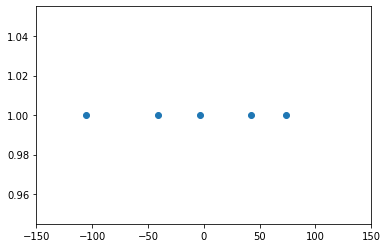

In [3]:

mean = ZeroMean(2)
time_step = 0.01
training_time = 0.12
testing_time = 1

max_x = 150
max_v = 30
n_train = 5
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))
train_starting_position=[-106.04535271  , -3.46845361 , -41.39813269  , 73.91917362,   41.96596604]
train_starting_velocity =[-17.65495202, 6.74286158,  16.20365852 , -4.81209128 ,-26.20602162]

print(train_starting_position)
print(train_starting_velocity)
data = get_damped_pendulum_data(time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch
plt.scatter(train_starting_position, np.ones(n_train))
plt.xlim(-150,150)

moi:516.36
known: 525.29
learnt: 525.27
[[-4.03641254e-09]
 [ 9.11460623e-02]]
[[-5.55426025e-08]
 [ 8.58305113e-02]
 [-2.75657565e-04]
 [-1.07858089e-02]]
known: 547.98
learnt: 522.20
[[-1.96572409e-04]
 [ 4.00019035e-01]]
[[ 0.00066799]
 [ 0.31726962]
 [-0.00128034]
 [-0.03253782]]


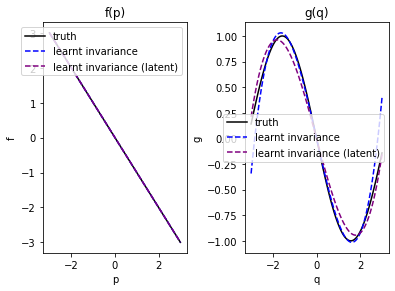

In [4]:

moi, *dump = get_GPR_model(get_MOI(), mean, data, 500)
print("moi:"+format(moi.log_marginal_likelihood().numpy(),".2f"))
jitter = 1e-4
invar_density = 40
invar_range = 3
poly_f_d = 2
poly_g_d = 4
known_kernel = get_invariance_kernel(DampedPendulumInvariance, invar_range, invar_density, jitter) #switch
known, *dump = get_GPR_model(known_kernel, PendulumEpsilonMean(known_kernel),data, 500)
print("known: "+format(known.log_marginal_likelihood().numpy(),".2f"))
learnt_kernel = get_parameterised_invariance_kernel(DampedPolynomialInvariance, invar_range, invar_density, jitter, poly_f_d, poly_g_d) #switch
model, fs, gs, coeff = get_GPR_model(learnt_kernel, PolynomialEpsilonMean(learnt_kernel), data, 3000, stored=True)
print("learnt: "+ format(model.log_marginal_likelihood().numpy(),".2f"))
print(learnt_kernel.f_poly.numpy())
print(learnt_kernel.g_poly.numpy())

known_kernel_latent = get_latent_invariance_kernel(PendulumLatentInvariance, invar_range, invar_density, jitter) #switch
known_latent, *dump = get_GPR_model(known_kernel_latent, mean, data, 500)
print("known: "+format(known_latent.log_marginal_likelihood().numpy(),".2f"))
learnt_kernel_latent = get_latent_parameterised_invariance_kernel(PolynomialLatentInvariance, invar_range, invar_density, jitter, poly_f_d, poly_g_d) #switch
model_latent, fs_latent, gs_latent, coeff_latent = get_GPR_model(learnt_kernel_latent, mean, data, 3000, stored=True)
print("learnt: " + format(model_latent.log_marginal_likelihood().numpy(),".2f"))
print(learnt_kernel_latent.f_poly.numpy())
print(learnt_kernel_latent.g_poly.numpy())

import matplotlib.pyplot as plt
from numpy.polynomial import polynomial
x = np.linspace(-3,3,100)
multiplier = -learnt_kernel.f_poly.numpy()[1]
multiplier_l = -learnt_kernel_latent.f_poly.numpy()[1]
f = polynomial.Polynomial(np.squeeze(learnt_kernel.f_poly.numpy()))
g = polynomial.Polynomial(np.squeeze(learnt_kernel.g_poly.numpy()))
f_l = polynomial.Polynomial(np.squeeze(learnt_kernel_latent.f_poly.numpy()))
g_l = polynomial.Polynomial(np.squeeze(learnt_kernel_latent.g_poly.numpy()))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, -x, label='truth', color="black")
ax1.plot(x, f(x)/multiplier, "--", color="blue", label='learnt invariance')
ax1.plot(x, f_l(x)/multiplier_l, "--", color="purple", label='learnt invariance (latent)')
ax1.set_title("f(p)")
ax1.set_xlabel("p")
ax1.set_ylabel("f")
ax1.legend()
ax2.set_title("g(q)")
ax2.plot(x, -np.sin(x), color="black", label='truth')
ax2.plot(x, g(x)/multiplier, "--", color="blue",label='learnt invariance')
ax2.plot(x, g_l(x)/multiplier_l, "--", color="purple",label='learnt invariance (latent)')
ax2.legend()
ax2.set_xlabel("q")
ax2.set_ylabel("g")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)



In [179]:
known

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.Ka.variance GPR.kernel.Ka.variance,Parameter,Sigmoid,,True,(),float64,9.999995938204572
GPR.mean_function.Ka.lengthscales GPR.kernel.Ka.lengthscales,Parameter,Sigmoid,,True,"(2,)",float64,[2.55372277 2.17952244]
GPR.mean_function.Kv.variance GPR.kernel.Kv.variance,Parameter,Sigmoid,,True,(),float64,4.827962743797653
GPR.mean_function.Kv.lengthscales GPR.kernel.Kv.lengthscales,Parameter,Sigmoid,,True,"(2,)",float64,[9.99999695 3.88638831]
GPR.mean_function.gamma,Parameter,Softplus,,True,(),float64,1.1220247963821296e-13
GPR.mean_function.epsilon GPR.kernel.epsilon,Parameter,Softplus + Shift,,True,(),float64,1.5030296013641569
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0000000000646572e-06


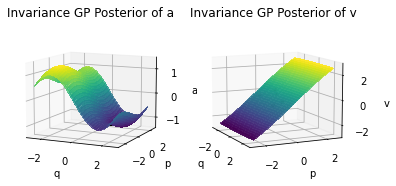

: 

In [7]:
import matplotlib.pyplot as plt
test_range = np.radians(150)
test_density = 40
test_xs = tf.linspace(-test_range,test_range,test_density)
test_vs = tf.linspace(-test_range,test_range,test_density)
test_xx, test_vv = tf.meshgrid(test_xs, test_vs)
test_points = tf.stack([tf.reshape(test_xx,[-1]), tf.reshape(test_vv,[-1])], axis=1)
pred, var = known_latent.predict_f(test_points) ######switch
X, Y = data
pred_a = pred[:int(pred.shape[0]/2),:]
var_a = var[:int(var.shape[0]/2),:]
pred_v = pred[int(pred.shape[0]/2):,:]
var_v = var[int(var.shape[0]/2):,:]
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
#ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.scatter(X[:,0], X[:,1],Y[:,1,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax1.view_init(10,-65)
ax1.set_xlabel("q")
ax1.set_ylabel("p")
ax1.set_zlabel("a") 
ax1.set_title("Invariance GP Posterior of a")

ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
#ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax2.scatter(X[:,0], X[:,1],Y[:,0,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax2.view_init(10,-25)
ax2.set_xlabel("q")
ax2.set_ylabel("p")
ax2.set_zlabel("v") 
ax2.set_title("Invariance GP Posterior of v")
plt.savefig("figures/posterior_damped_pendulum_invariance_latent.pdf")

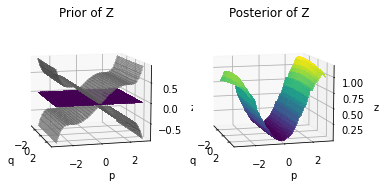

In [195]:

test_range = 3
test_density = 40
test_xs = tf.linspace(-test_range,test_range,test_density)
test_vs = tf.linspace(-test_range,test_range,test_density)
test_xx, test_vv = tf.meshgrid(test_xs, test_vs)
test_points = tf.stack([tf.reshape(test_xx,[-1]), tf.reshape(test_vv,[-1])], axis=1)
pred = tf.zeros((test_points.shape[0], 1), dtype=tf.float64)
X, Y = data
n = X.shape[0]
m = test_points.shape[0]
FullLatent = FullPendulumLatentInvariance(known_kernel_latent)
X1X2 = FullLatent(X, test_points)
X1X1 = FullLatent(X)
X2X2 = FullLatent(test_points)
A = X1X1[:2*n,:2*n]
B = X1X2[:2*n, 2*m:]
C = tf.transpose(B)
D = X2X2[2*m:,2*m:]
y = tf.reshape(tf.transpose(tf.concat([Y[:,1,None],Y[:,0,None]],1)),(Y.shape[0]*2,1))
mean = tf.tensordot(tf.tensordot(C,tf.linalg.inv(A),1), y,1)
cov = D-tf.tensordot(tf.tensordot(C, tf.linalg.inv(A),1), B,1)
var_prior = tf.linalg.diag_part(D)
var_post = tf.linalg.diag_part(cov)

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"})

ax1.plot_surface(test_xx, test_vv, tf.reshape(pred, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_prior, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_prior, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.view_init(10,-15)
ax1.set_xlabel("q")
ax1.set_ylabel("p")
ax1.set_zlabel("z") 
ax1.set_title("Prior of Z")

ax2.plot_surface(test_xx, test_vv, tf.reshape(mean, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
#ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_post, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_post, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax2.view_init(10,-15)
ax2.set_xlabel("q")
ax2.set_ylabel("p")
ax2.set_zlabel("z") 
ax2.set_title("Posterior of Z")


plt.savefig("figures/latent_damped_pendulum.pdf")

0
-108.9619368033375
-15.952230620748187
0.0012918516282350067
0.0012155482512241978
0.001315478897495314
0.0012605365551797809
0.001352850688127542


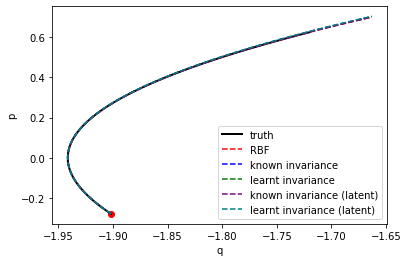

MSE & 0.0013 & 0.0012 & 0.0013 & 0.0013 & 0.0014 \\
1
-135.6035670994194
-23.967239670824974
0.0020203876012830197
0.00034383945053139455
0.0004115634391299342
0.00044203968824248105
6.530960308216753e-05


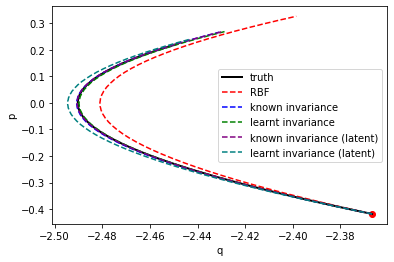

MSE & 0.0017 & 0.0008 & 0.0009 & 0.0009 & 0.0007 \\
2
-23.766645615604507
1.1597961907037053
0.00019280239310802934
0.0002006978736006129
0.0001787976363934051
0.00018536216552300904
0.00017339783350074484


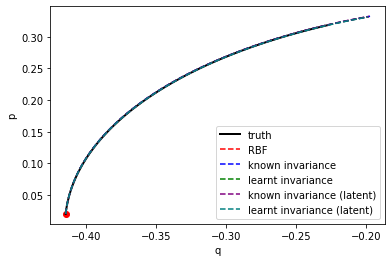

MSE & 0.0012 & 0.0006 & 0.0006 & 0.0006 & 0.0005 \\
3
77.04220099063215
14.204166501613601
0.0013201822092438339
0.0012454975037482603
0.0013045811130881478
0.0012985222999084367
0.0012941143741334604


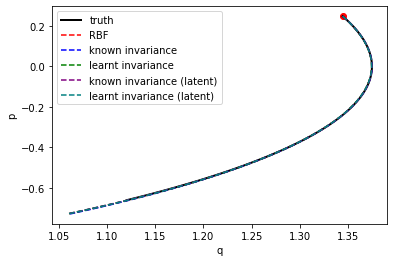

MSE & 0.0012 & 0.0008 & 0.0008 & 0.0008 & 0.0007 \\
4
-142.30685930340752
-21.925746046182084
0.002455618392358864
0.00020303993494506388
0.00023892763357719955
0.0003040283688485247
2.6629640557370623e-05


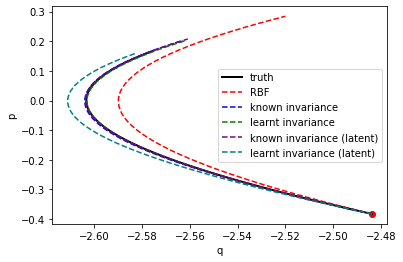

MSE & 0.0015 & 0.0006 & 0.0007 & 0.0007 & 0.0006 \\
5
-2.409433844984079
26.53575996812799
0.00025531711193730656
0.0002607243439531458
0.00026610100592428394
0.00025996275100446784
0.00025869755081653605


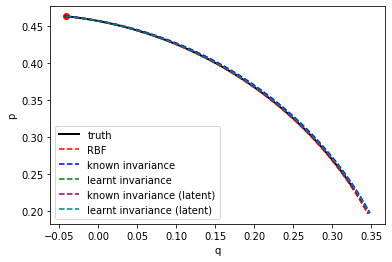

MSE & 0.0013 & 0.0006 & 0.0006 & 0.0006 & 0.0005 \\
6
62.47363042559601
-2.529000656692382
0.0009824302634276927
0.0010546594248280828
0.0010147284981862458
0.0010375186749653098
0.0010179308096499994


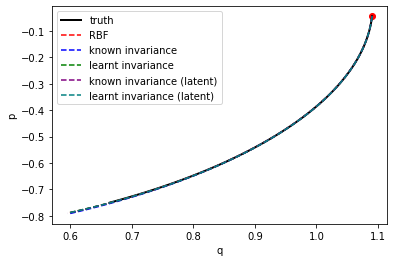

MSE & 0.0012 & 0.0006 & 0.0007 & 0.0007 & 0.0006 \\
7
96.3918095863163
11.320514067673614
0.0019462779060309885
0.0012847090774078934
0.0015252980433555052
0.0014347819853298117
0.0013801567667601745


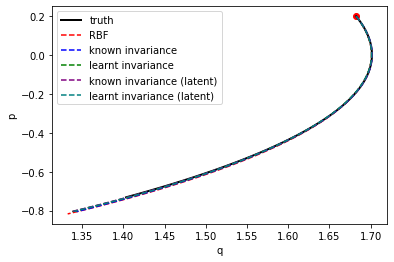

MSE & 0.0013 & 0.0007 & 0.0008 & 0.0008 & 0.0007 \\
8
-116.83268443320135
8.968051334983215
0.0014340239283028584
0.0015564601572654148
0.0016358989995907366
0.0016411029075425012
0.0016988953373281183


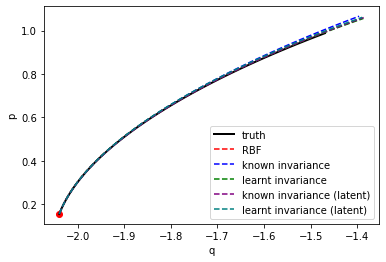

MSE & 0.0013 & 0.0008 & 0.0009 & 0.0009 & 0.0008 \\
9
40.226377082448266
-14.27944181346161
0.0005633008030419178
0.0005475757756665637
0.0005571103295977706
0.0005441958807589285
0.0005560814330061736


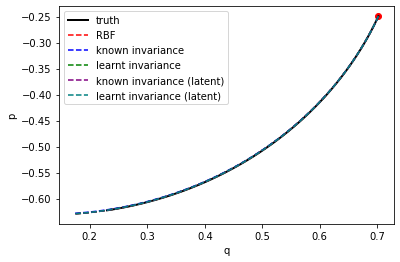

MSE & 0.0012 & 0.0008 & 0.0008 & 0.0008 & 0.0008 \\


: 

In [199]:


eva_future_moi = []
eva_future_inv = []
eva_future_inv_p = []
eva_future_inv_l = []
eva_future_inv_lp = []

dynamics = damped_pendulum_dynamics

# pendulum
def energy(X):
    return 0.5*tf.square(X[:,1])-np.cos(X[:,0])

for i in range(10):
    print(i)
    test_starting_position = np.radians(np.random.uniform(-max_x, max_x))
    test_starting_velocity = np.radians(np.random.uniform(-max_v, max_v))

    print(np.degrees(test_starting_position))
    print(np.degrees(test_starting_velocity))
    test_starting = (test_starting_position, test_starting_velocity)
    time_setting = (testing_time, time_step)

    evaluate_moi = evaluate_model_future(moi, test_starting, dynamics,time_setting, energy)
    eva_future_moi.append(evaluate_moi[0])
    print(evaluate_moi[0])

#    fig, ax = plt.subplots()
#    plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
#    plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="truth", color="black", linewidth=2)
#    plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
#    plt.show()

    evaluate_invariance =evaluate_model_future(known, test_starting, dynamics,time_setting, energy)
    eva_future_inv.append(evaluate_invariance[0])
    print(evaluate_invariance[0])
#    plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
#    plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="truth", color="black", linewidth=2)
#    plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
#    plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
#    plt.show()

    evaluate_invariance_p =evaluate_model_future(model, test_starting, dynamics, time_setting, energy)#, (m.kernel.inv_f, m.kernel.inv_g), (lambda x: x, lambda x:np.sin(x)))
    eva_future_inv_p.append(evaluate_invariance_p[0])
    print(evaluate_invariance_p[0])

    evaluate_invariance_l = evaluate_model_future(known_latent, test_starting, dynamics,time_setting, energy)
    eva_future_inv_l.append(evaluate_invariance_l[0])
    print(evaluate_invariance_l[0])

    evaluate_invariance_lp = evaluate_model_future(model_latent, test_starting, dynamics, time_setting, energy)#, (m.kernel.inv_f, m.kernel.inv_g), (lambda x: x, lambda x:np.sin(x)))
    eva_future_inv_lp.append(evaluate_invariance_lp[0])
    print(evaluate_invariance_lp[0])

    fig, ax = plt.subplots()
    plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
    plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="truth", color="black", linewidth=2)
    plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
    plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
    plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
    plt.plot(evaluate_invariance_l[1][:,0],evaluate_invariance_l[1][:,1], "--", label="known invariance (latent)", color="purple")
    plt.plot(evaluate_invariance_lp[1][:,0],evaluate_invariance_lp[1][:,1], "--", label="learnt invariance (latent)", color="teal")
    plt.xlabel("q")
    plt.ylabel("p")
    plt.legend()
    plt.show()
    print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((np.mean(eva_future_inv_p)),".4f")+" & "+format((np.mean(eva_future_inv_l)),".4f")+" & "+format((np.mean(eva_future_inv_lp)),".4f")+ ' \\\\')



In [182]:
print("Log Marginal Likelihood & " + format((moi.log_marginal_likelihood().numpy()),".0f")+" & "+ format((known.log_marginal_likelihood().numpy()),".0f") + " & "+ format((model.log_marginal_likelihood().numpy()),".0f") +" & "+ format((known_latent.log_marginal_likelihood().numpy()),".0f") + " & "+ format((model_latent.log_marginal_likelihood().numpy()),".0f")+ ' \\\\')
print("MSE & "+ format((np.mean(eva_future_moi)),".5f")+" & "+format(np.mean(eva_future_inv),".5f")+" & "+format((np.mean(eva_future_inv_p)),".5f")+" & "+format((np.mean(eva_future_inv_l)),".5f")+" & "+format((np.mean(eva_future_inv_lp)),".5f")+ ' \\\\')

Log Marginal Likelihood & 516 & 525 & 525 & 548 & 522 \\
MSE & 0.00179 & 0.00106 & 0.00111 & 0.00112 & 0.00094 \\


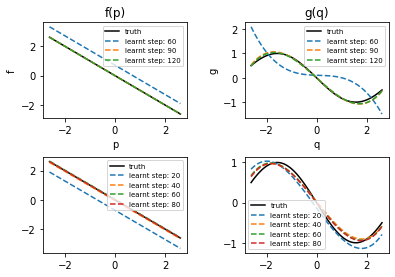

In [191]:

import matplotlib.pyplot as plt
from numpy.polynomial import polynomial
x = np.linspace(-np.radians(150),np.radians(150),100)
fig, (axs) = plt.subplots(2, 2)
axs[0][0].plot(x, -x, label='truth', color="black")
axs[0][1].plot(x, -np.sin(x), color="black", label='truth')
axs[1][0].plot(x, -x, label='truth', color="black")
axs[1][1].plot(x, -np.sin(x), color="black", label='truth')
axs[0][0].set_title("f(p)")
axs[0][0].set_xlabel("p")
axs[0][0].set_ylabel("f")
axs[0][1].set_title("g(q)")
axs[0][1].set_xlabel("q")
axs[0][1].set_ylabel("g")
for i, (f, g) in enumerate(zip(fs, gs)):
    if i%3==0 and i>3:
        multiplier = -learnt_kernel.f_poly.transform(f[1])
        f = polynomial.Polynomial(np.squeeze(learnt_kernel.f_poly.transform(f)))
        g = polynomial.Polynomial(np.squeeze(learnt_kernel.g_poly.transform(g)))
        axs[0][0].plot(x, f(x)/multiplier, "--", label='learnt step: '+str(i*10))
        axs[0][1].plot(x, g(x)/multiplier, "--", label='learnt step: '+ str(i*10))
for i, (f, g) in enumerate(zip(fs_latent, gs_latent)):
    if i%2==0 and i>0:
        multiplier = -learnt_kernel_latent.f_poly.transform(f[1])
        f = polynomial.Polynomial(np.squeeze(learnt_kernel_latent.f_poly.transform(f)))
        g = polynomial.Polynomial(np.squeeze(learnt_kernel_latent.g_poly.transform(g)))
        axs[1][0].plot(x, f(x)/multiplier, "--", label='learnt step: '+str(i*10))
        axs[1][1].plot(x, g(x)/multiplier, "--", label='learnt step: '+ str(i*10))
axs[0][0].legend(loc=1, prop={"size":7})
axs[0][1].legend(loc=1, prop={"size":7})
axs[1][0].legend(loc=1, prop={"size":7})
axs[1][1].legend(loc=3, prop={"size":7})
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig("figures/damped_pendulum_learnt_over_time.pdf")



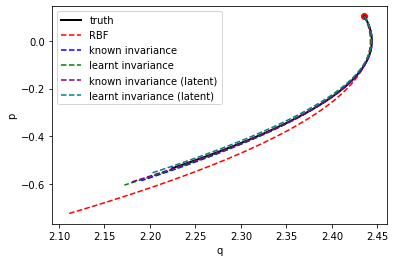

In [192]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
plt.plot(evaluate_invariance_l[1][:,0],evaluate_invariance_l[1][:,1], "--", label="known invariance (latent)", color="purple")
plt.plot(evaluate_invariance_lp[1][:,0],evaluate_invariance_lp[1][:,1], "--", label="learnt invariance (latent)", color="teal")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
plt.savefig("figures/damped_pendulum_predicted.pdf")

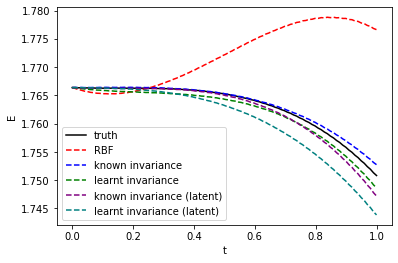

In [193]:
t = np.linspace(0, testing_time, int(testing_time/time_step))
plt.plot(t, tf.squeeze(evaluate_invariance[5])+1, label="truth", color="black")
plt.plot(t, tf.squeeze(evaluate_moi[6])+1, "--", label="RBF", color="red")
plt.plot(t, tf.squeeze(evaluate_invariance[6])+1,"--" ,  label="known invariance", color="blue")
plt.plot(t, tf.squeeze(evaluate_invariance_p[6])+1, "--",label="learnt invariance", color="green")
plt.plot(t, tf.squeeze(evaluate_invariance_l[6])+1,"--" ,  label="known invariance (latent)", color="purple")
plt.plot(t, tf.squeeze(evaluate_invariance_lp[6])+1, "--",label="learnt invariance (latent)", color="teal")
plt.legend()
plt.xlabel("t")
plt.ylabel("E")
plt.savefig("figures/damped_pendulum_energy.pdf")

In [ ]:

import importlib, sys
importlib.reload(sys.modules["invariance_functions"])
from invariance_functions import evaluate_model_future